### Imports and Parameter setting

In [3]:
import os
os.chdir('/Users/benjaminshih/opt/miniconda3/envs/filer/lib/python3.8/site-packages')
%matplotlib inline
%config InlineBackend.figure_format='retina'
%load_ext autoreload
%autoreload 2
import requests
import matplotlib as mpl
import pandas as pd
from matplotlib import rc
import matplotlib.pyplot as plt
import ipyigv
from ipyigv import IgvBrowser as Browser, PUBLIC_GENOMES
from ipyigv.options import ReferenceGenome, Track
import seaborn as sns

#aesthetic params
nord = ['8fbcbb', '81a1c1', 'bf616a', 'd08770', 'ebcb8b', 'a3be8c', 'b48ead', 'd8dee9']
nord_hex = ["#"+i for i in nord]
custom_colors = mpl.cycler('color', nord)
mpl.rcParams['axes.prop_cycle'] = custom_colors
mpl.rcParams['figure.dpi'] = 300

rc('font',**{'family':'serif','serif':['Times']})
#rc('text', usetex=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#global vars
FILER_URL= 'https://tf.lisanwanglab.org/FILER'

data_region = 'get_data_region.php' 
metadata = 'get_metadata.php'
overlap_track = 'get_overlapping_tracks_by_coord.php'

In [3]:
def request_data(base_url: str, endpoint: str, params: dict) -> "JSON":
    """
    Returns the JSON data for a particular endpoint (one of track data, metadata or overlap data) and 
    particular parameters

    Parameters:
        base_url (str): FILER or GADB base URL to fetch from
        endpoint (str): endpoint to fetch from, either data region, metadata, or overlapping tracks
        params (dict): request-specific parameters
        
    Returns:
        JSON dictionary containing API call data
    """
    r = requests.get(base_url + "/" + endpoint, params=params)
    data = r.json()
    
    if r.status_code != requests.codes.ok:
        print("Request failed")
        return
    
    return data

### Data Region example

Text(0.5, 0, 'Signal Value')

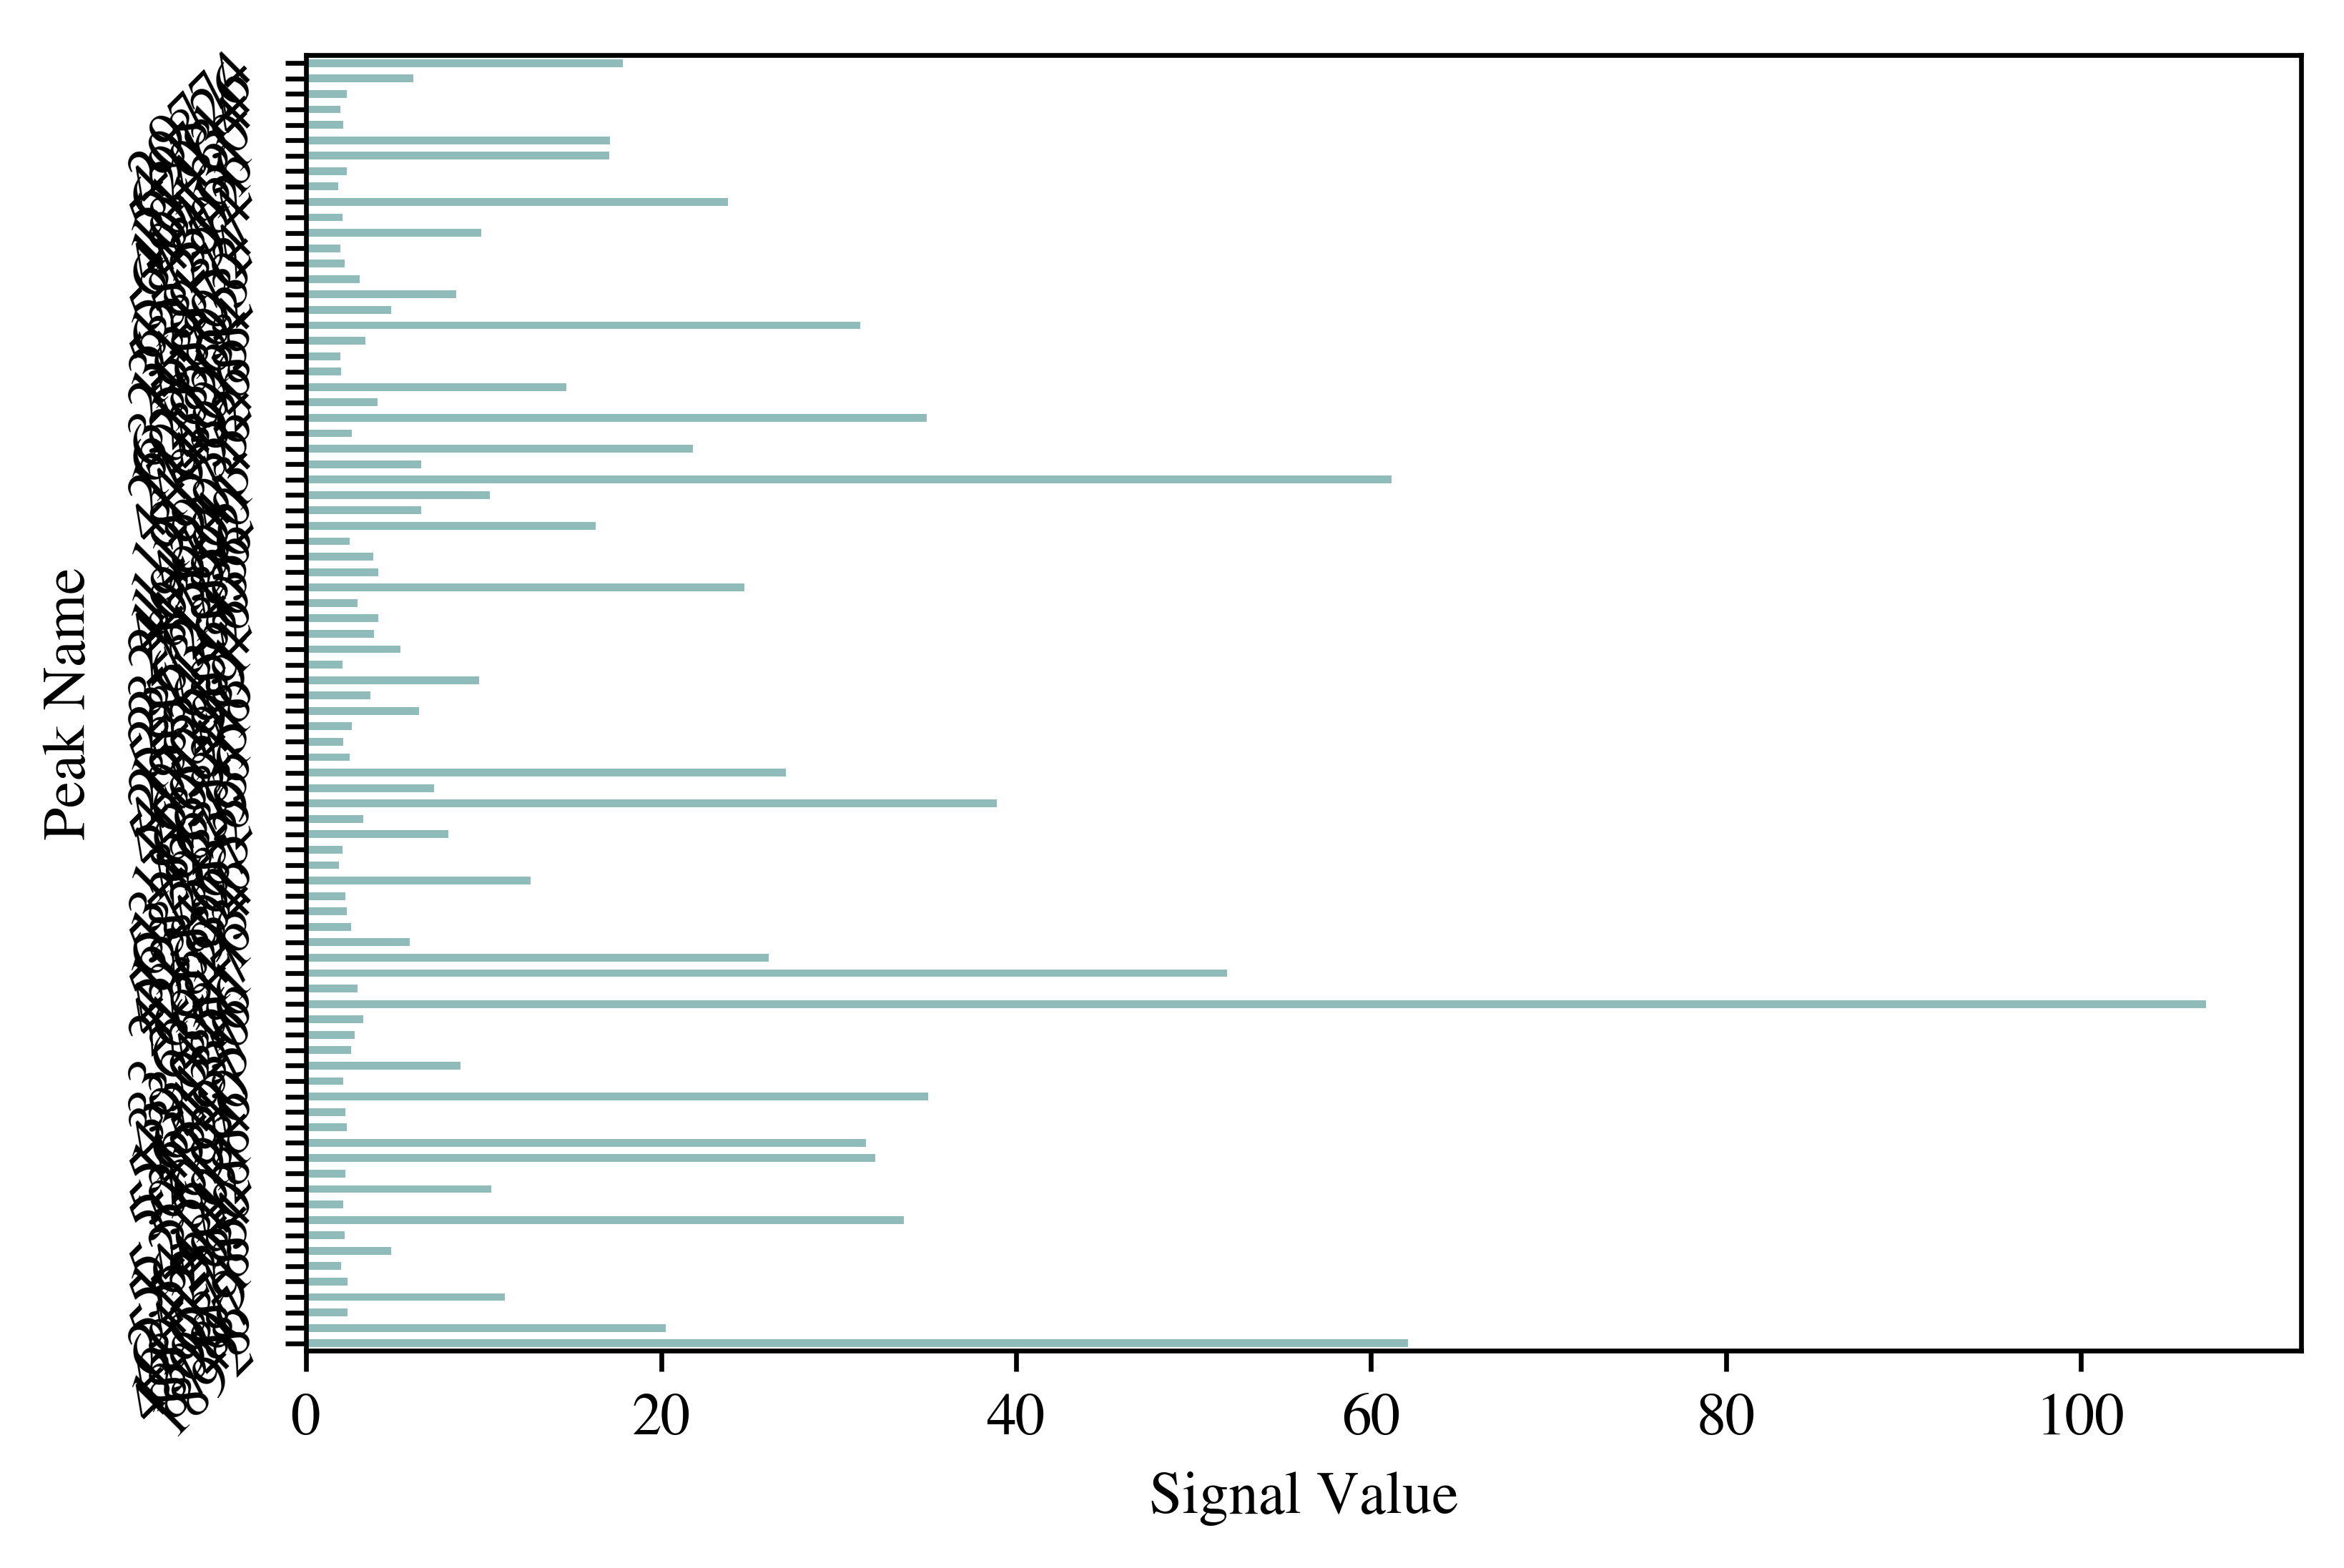

In [4]:
data = request_data(FILER_URL, data_region, {'region':'chr1:10000-1500000','track':'NGEN000610'})
df = pd.DataFrame(data)
df = df[["name", "signalValue"]]
df["name"] = df["name"].apply(lambda x: x[5:])
df.plot(x="name", y="signalValue", kind="barh", legend=False)
plt.ylabel("Peak Name")
plt.yticks(rotation=45)
plt.xlabel("Signal Value")
# df = df[["chr", "peak", "start"]]
# df = df.pivot_table(values='peak',index='start',columns='chr')
# print(df.head())
# sns.heatmap(df)

### Metadata Example

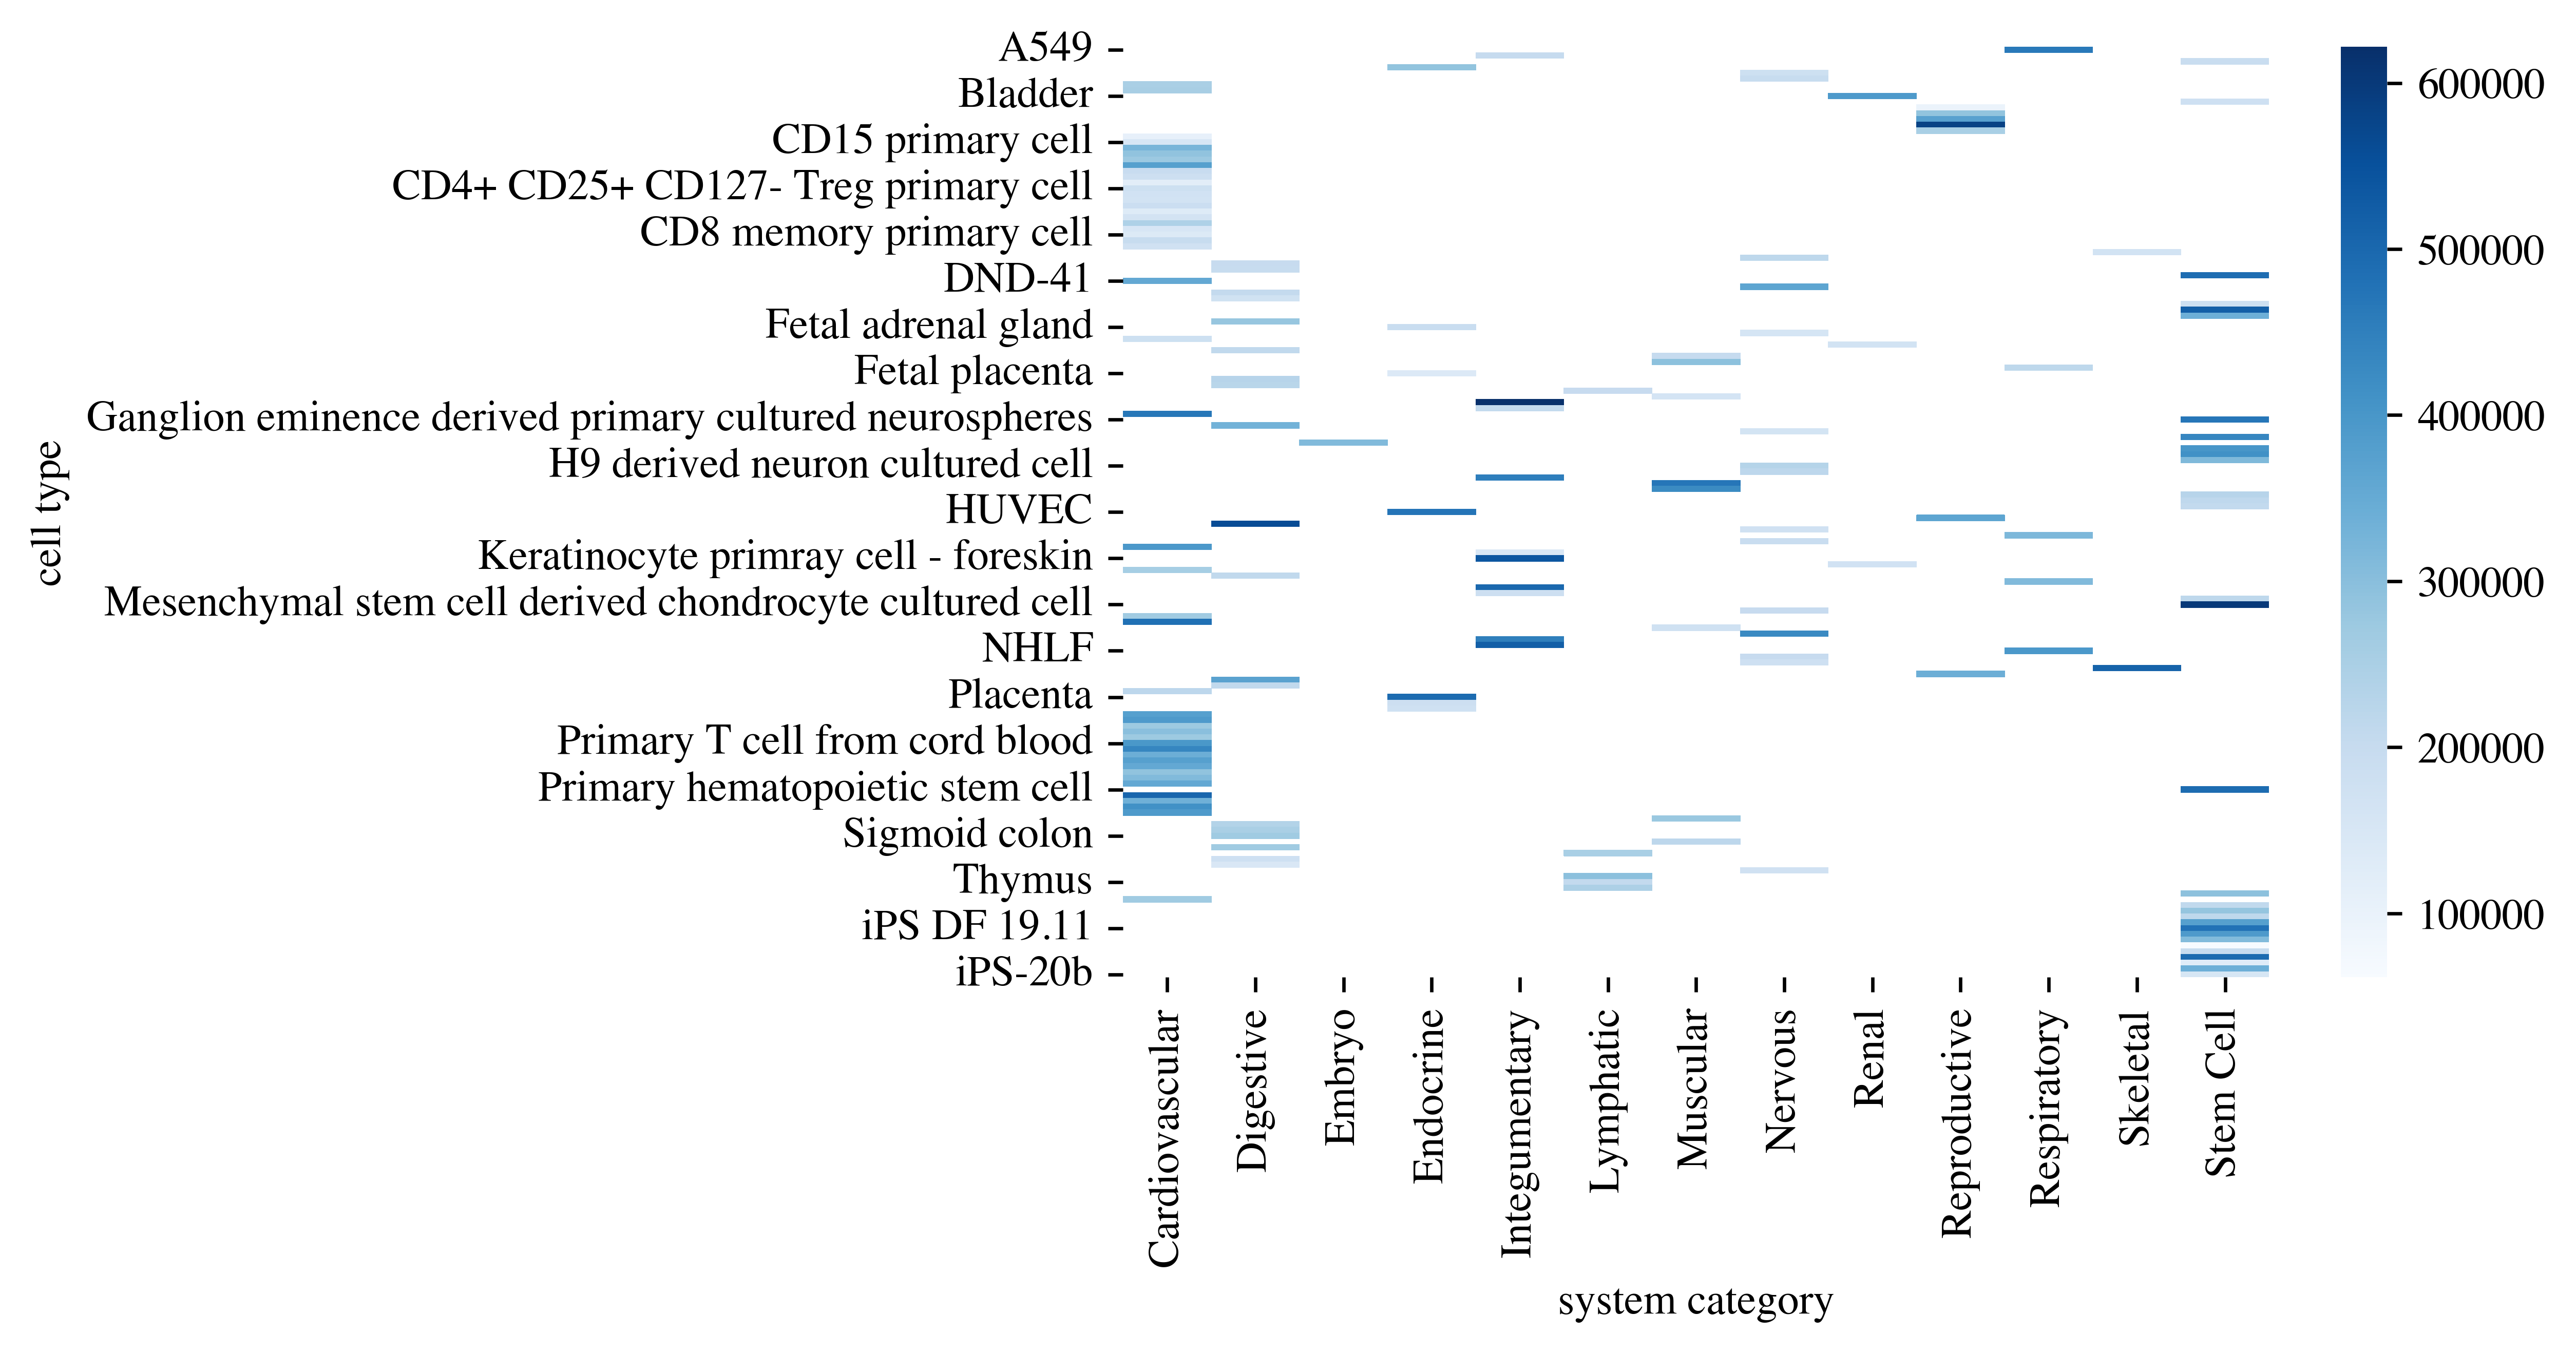

In [22]:
data = request_data(FILER_URL, metadata, 
                    {'genomeBuild':'hg19', 'dataSource':'ROADMAP', 'assayType':'ChIP-seq'})
df = pd.DataFrame(data)
df = df[["cell type", "system category", "Number of intervals"]]
df = df.pivot_table(values='Number of intervals',index='cell type',columns='system category')
sns.heatmap(df, cmap="Blues")

### Overlap Region example

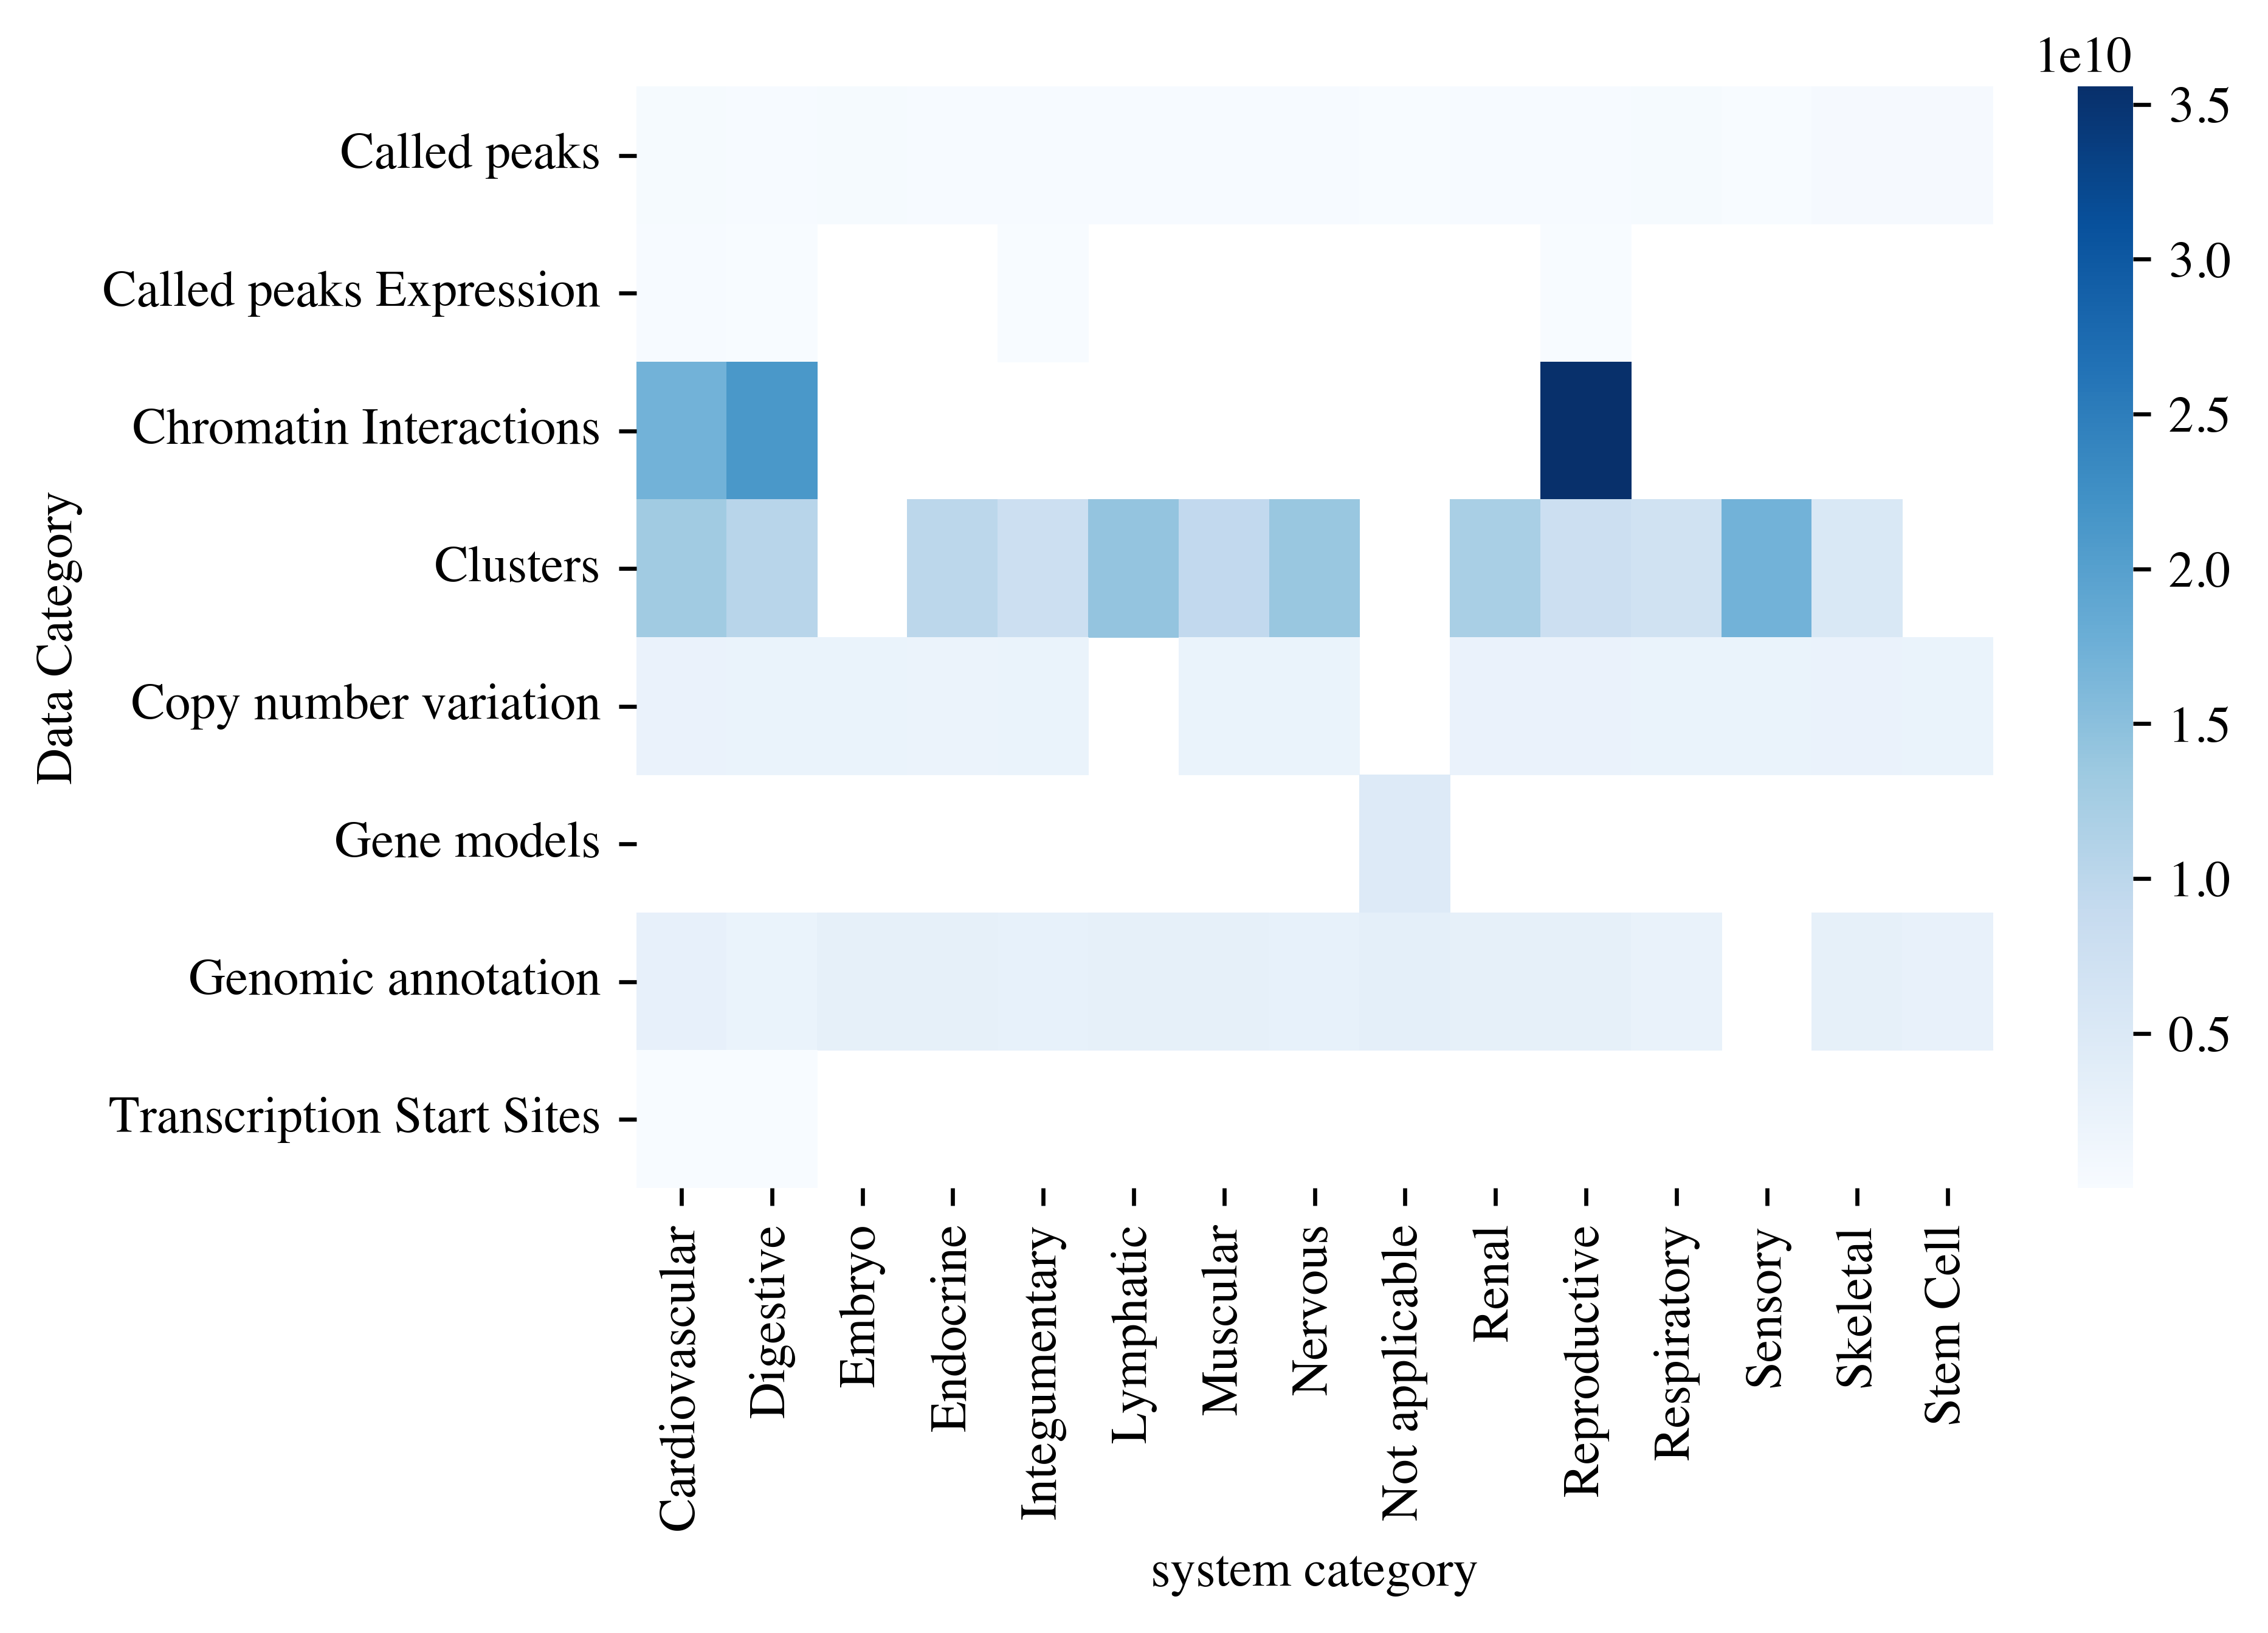

In [6]:
data = request_data(FILER_URL, overlap_track, {'genomeBuild':'hg19', 'region':'chr1:1103243-1103243', 
                                               'filterString':'.', 'outputFormat':'json'})
df = pd.DataFrame(data)
df = df[df.columns.difference(["wget command", "tabix_index Download", "Link out URL", "File name", "Raw File URL", "Raw file download", "Raw file md5", "Processed file md5", \
                               "Processed File Download URL", "filepath", "File format", "File size", "Downloaded date", "Date added to GADB", "Release date"])]
df = df[["Data Category", "system category", "bp covered"]]
df = df.pivot_table(values='bp covered',index='Data Category',columns='system category')
sns.heatmap(df, cmap="Blues")

## IGV Visualization

#### Visualize Query
Demonstrates visualization of relevant genomic tracks onto an IGV visualization; handles querying FILER API and returning data relevant to user passed parameters related to region, tissue, classification, etc.

In [13]:
genome = ReferenceGenome(**PUBLIC_GENOMES.hg19)
browser = Browser(genome=genome)

In [ ]:
curr_track_dict = {
              'name': 'Track ',
              'format': 'bed',
              'url': "https://tf.lisanwanglab.org/GADB/www/get_data_region.php?region=chr1:10000-1500000&track=NGEN000610",
              'indexed': False,
              'visibilityWindow': -1,
              'removable': False,
              'order': 1000000
        }
curr_track = Track(**curr_track_dict)
browser.add_track(curr_track)
browser

In [15]:
def visualize_query(region: str, tissue=None, classification=None):
    """
    IGV vizualization given a region and tissue type.
    
    Parameters:
        region (str): Chromosomal region. ex. "chr1:1103243-1103243"
        tissue (str): tissue type, defaults to None and returns all IGV for a region. ex. Digestive
        classification (str): classification type, defaults to None and returns all IGV inclusive of all classifications. ex. DNase-seq peaks
    
    Brute force arbitrary truncate for now -- stop from crashing due to overload track adding
        Possible resolutions:
        - Caching (not likely due to no overlap in queries)
        - smart subsetting with some logic for relevancy
    """
    data = request_data(FILER_URL, overlap_track, {'genomeBuild':'hg19', 'region': region, 
                                               'filterString':'.', 'outputFormat':'json'})
    if isinstance(data, list):
        df = pd.DataFrame(data)
    else:
        df = pd.DataFrame.from_dict(data, orient='index').T
    
    if not tissue and not classification:
        #default IGV of all tracks in region
        df = df["Processed File Download URL"][:5]
    
    elif tissue and not classification:
        #IGV for all tracks in region of specified tissue type
        df = df.loc[df['system category'] == tissue][:5]
        df = df["Processed File Download URL"]
        print(df.head())
    
    elif not tissue and classification:
        #IGV for all tracks in region of specified classification
        df = df.loc[df['classification'] == classification][:5]
        df = df["Processed File Download URL"]
        
    elif tissue and classification:
        #IGV for all tracks in region when given BOTH tissue and classification
        df = df.loc[df['system category'] == tissue and df['classification'] == classification][:5]
        df = df["Processed File Download URL"]
        
    else:
        #Unhandled exception
        print("Unhandled exception")
        return
        
    for i,url in enumerate(df):
        curr_track_dict = {
              'name': 'Track ' + str(i),
              'format': 'bed',
              'url': url,
              'indexed': False,
              'visibilityWindow': -1,
              'removable': False,
              'order': 1000000
        }
        curr_track = Track(**curr_track_dict)
        browser.add_track(curr_track)

In [16]:
visualize_query('chr1:1103243-1103243', "Skeletal")

80     https://tf.lisanwanglab.org/GADB/Annotationtra...
260    https://tf.lisanwanglab.org/GADB/Annotationtra...
261    https://tf.lisanwanglab.org/GADB/Annotationtra...
262    https://tf.lisanwanglab.org/GADB/Annotationtra...
263    https://tf.lisanwanglab.org/GADB/Annotationtra...
Name: Processed File Download URL, dtype: object


In [18]:
#Reset Browser instance (otherwise tracks from separate queries stack)
%reset_selective -f browser
genome = ReferenceGenome(**PUBLIC_GENOMES.hg19)
browser = Browser(genome=genome)

# Miscellaneous Plots

Generated plots from FILER API calls

In [6]:
#overlap region example
data = request_data(FILER_URL, overlap_track, {'genomeBuild':'hg19', 'region':'chr1:1103243-1103243', 
                                               'filterString':'.', 'outputFormat':'json'})
df = pd.DataFrame(data)
df.head()

,Identifier,Data Source,File name,Number of intervals,bp covered,Output type,Genome build,cell type,Biosample type,Biosamples term id,...,wget command,tabix_index Download,Link out URL,Raw File URL,Raw file download,Raw file md5,Data Category,classification,original cell type name,system category
0,NGEN004055,ENCODE,ENCFF237NQC.bed.gz,144749,21683857,peaks,hg19,8988T,cell line,EFO:0005713,...,wget https://tf.lisanwanglab.org/GADB/Annotati...,wget https://tf.lisanwanglab.org/GADB/Annotati...,https://www.encodeproject.org,https://www.encodeproject.org/files/ENCFF237NQ...,wget https://tf.lisanwanglab.org/GADB/Annotati...,1c1ecd5f4fb68e6404e870473f1f8148,Called peaks,DNase-seq peaks,8988T,Digestive
1,NGEN011624,ENCODE,ENCFF729HDN.bed.gz,116678,41574526,hotspots,hg19,8988T,cell line,EFO:0005713,...,wget https://tf.lisanwanglab.org/GADB/Annotati...,wget https://tf.lisanwanglab.org/GADB/Annotati...,https://www.encodeproject.org,https://www.encodeproject.org/files/ENCFF729HD...,wget https://tf.lisanwanglab.org/GADB/Annotati...,ec9d307083742dc68841ee95cffbc5bd,Called peaks,DNase-seq hotspots,8988T,Digestive
2,NGEN000003,ENCODE,ENCFF000AIL.bed.gz,135357,485114878,peaks,hg19,A549,cell line,EFO:0001086,...,wget https://tf.lisanwanglab.org/GADB/Annotati...,wget https://tf.lisanwanglab.org/GADB/Annotati...,https://www.encodeproject.org,https://www.encodeproject.org/files/ENCFF000AI...,wget https://tf.lisanwanglab.org/GADB/Annotati...,c1c2485b6a16df7c288adbda48a435a9,Called peaks,ChIP-seq H3K4me1-histone-mark peaks,A549,Respiratory
3,NGEN000034,ENCODE,ENCFF000LBT.bed.gz,150822,6502219004,clusters,hg19,A549,cell line,EFO:0001086,...,wget https://tf.lisanwanglab.org/GADB/Annotati...,wget https://tf.lisanwanglab.org/GADB/Annotati...,https://www.encodeproject.org,https://www.encodeproject.org/files/ENCFF000LB...,wget https://tf.lisanwanglab.org/GADB/Annotati...,a55d1d5fe467d63fe98bd3d0e5c8d436,Clusters,RNA-PET clusters,A549,Respiratory
4,NGEN000036,ENCODE,ENCFF000LCP.bed.gz,141294,5423643057,clusters,hg19,A549,cell line,EFO:0001086,...,wget https://tf.lisanwanglab.org/GADB/Annotati...,wget https://tf.lisanwanglab.org/GADB/Annotati...,https://www.encodeproject.org,https://www.encodeproject.org/files/ENCFF000LC...,wget https://tf.lisanwanglab.org/GADB/Annotati...,596719ed8e956dc972602fb84f26be99,Clusters,RNA-PET clusters,A549,Respiratory


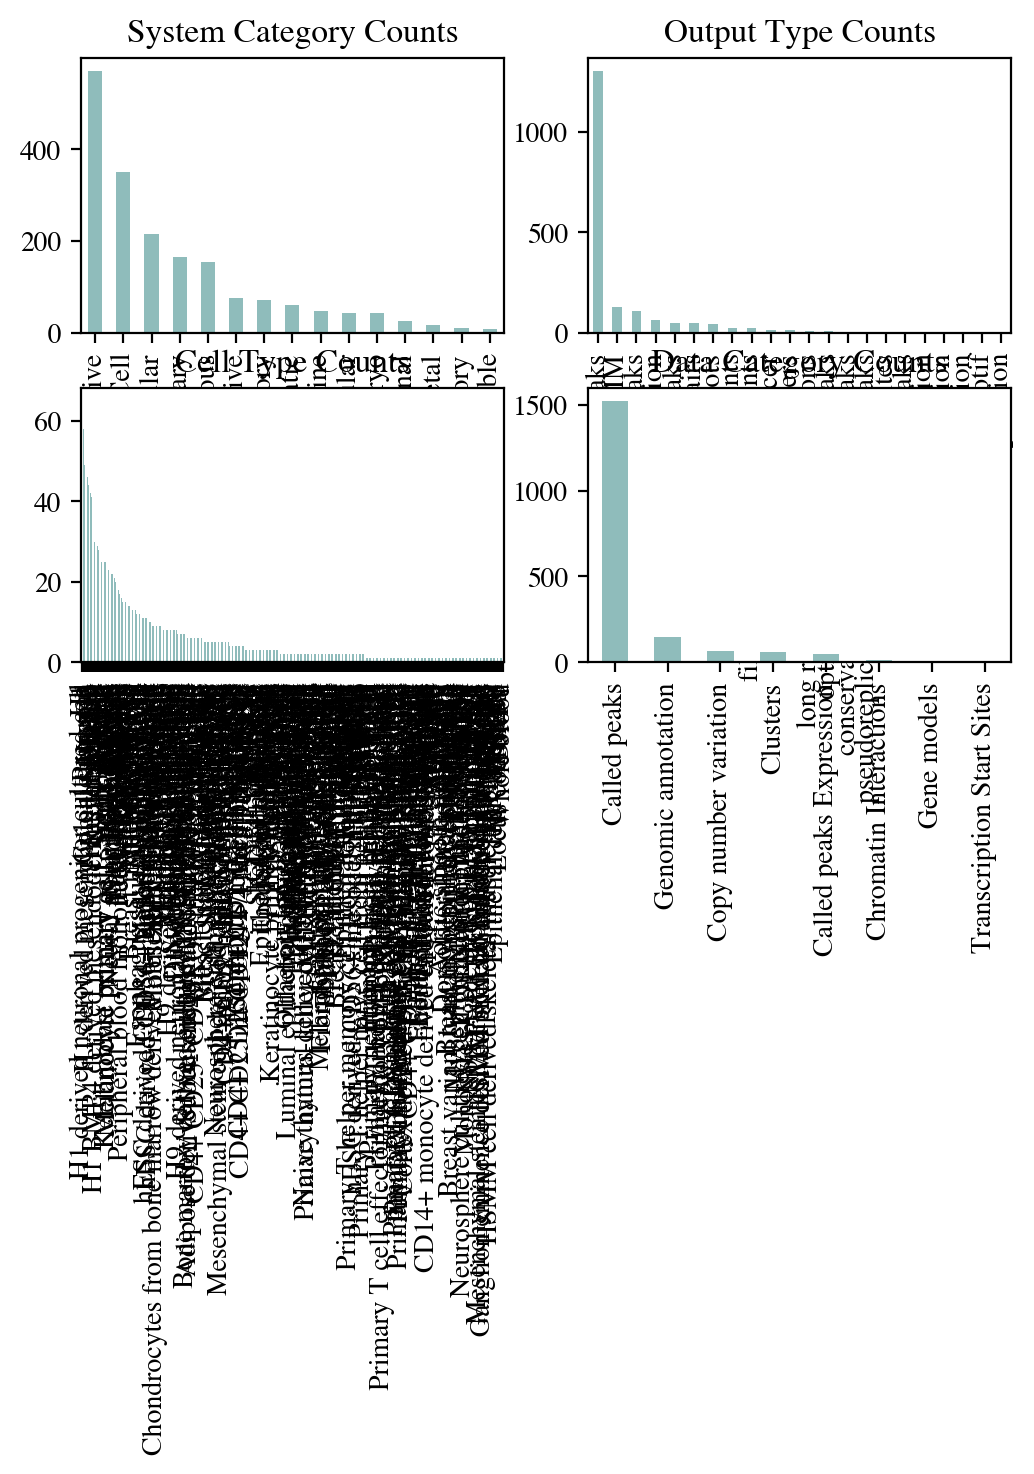

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2)
df["system category"].value_counts().plot(kind="bar", title="System Category Counts", ax=axes[0,0])
df["Output type"].value_counts().plot(kind="bar", title="Output Type Counts", ax=axes[0,1])
df["cell type"].value_counts().plot(kind="bar", title="Cell Type Counts", ax=axes[1,0])
df["Data Category"].value_counts().plot(kind="bar", title="Data Category Counts", ax=axes[1,1])

Text(0, 0.5, 'Count')

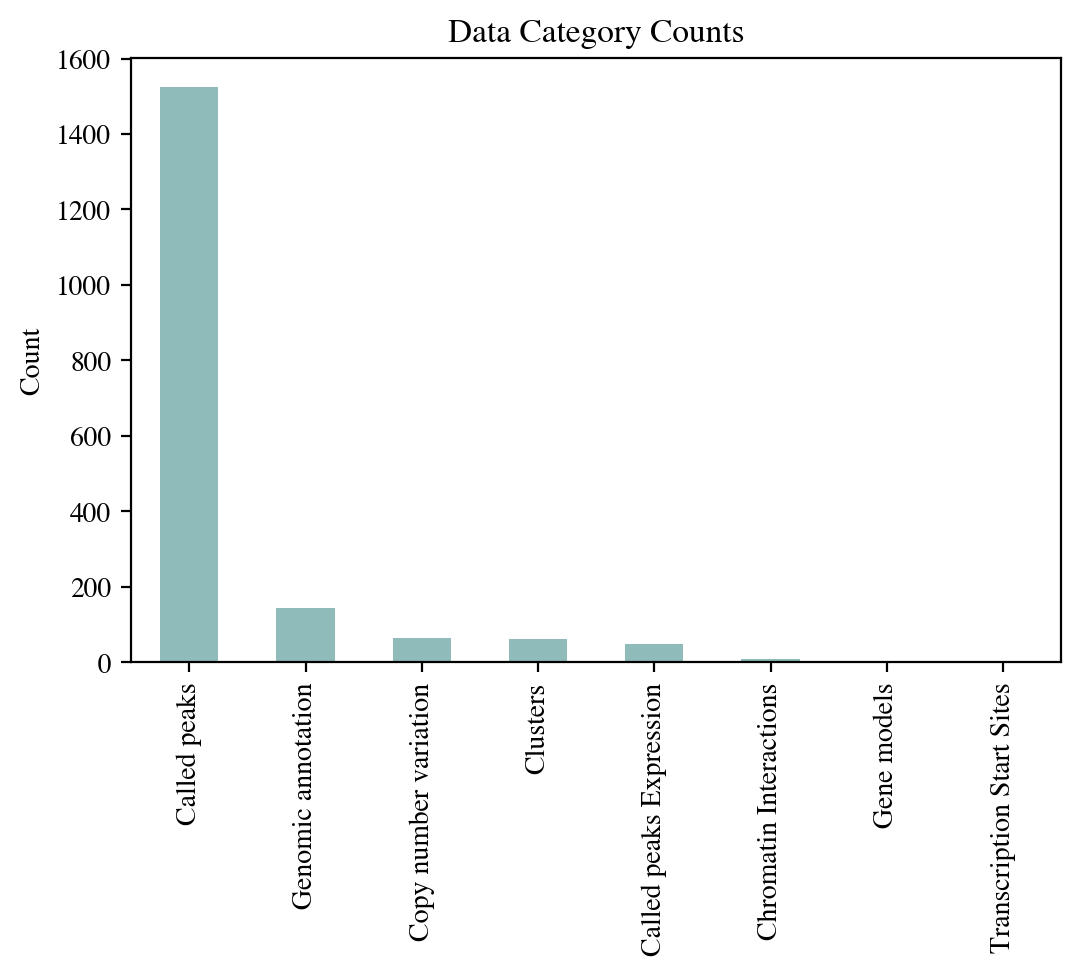

In [16]:
df["Data Category"].value_counts().plot(kind="bar", title="Data Category Counts")
plt.ylabel("Count")

In [8]:
df["system category"].value_counts().plot(kind="bar", title="System Category Counts")
plt.ylabel("Count")

KeyError: 'system category'

- User cam select which two attributes to visualize from an overlap from a dropdown
(plotly package)
- Various plots “classification index”
- Filter json directly for speed/plotly can do it?
- User input for region and track
- Push to personal GitHub
- RMarkup (RMD) (Rshiny)

In [13]:
import plotly.graph_objects as go
#fig = go.Figure(data=go.Bar(y=[2, 3, 1]))
#fig.write_html('first_figure.html', auto_open=True)
import plotly.express as px
fig = px.density_heatmap(df, x="total_bill", y="tip")
fig.write_html("first_figure.html", auto_open=True)

In [14]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.graph_objects as go

app = dash.Dash(__name__)

app.layout = html.Div([
    html.P("Color:"),
    dcc.Dropdown(
        id="dropdown",
        options=[
            {'label': x, 'value': x}
            for x in ['Gold', 'MediumTurquoise', 'LightGreen']
        ],
        value='Gold',
        clearable=False,
    ),
    dcc.Graph(id="graph"),
])

@app.callback(
    Output("graph", "figure"), 
    [Input("dropdown", "value")])
def display_color(color):
    fig = go.Figure(
        data=go.Bar(y=[2, 3, 1], marker_color=color))
    return fig

app.run_server(debug=True)

ModuleNotFoundError: No module named 'dash_core_components'